## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data & Drop NaN Values

In [2]:
df = pd.read_csv("C:/Users/park9/pytorch/AI_class/data/WISDM_ar_v1.1_raw.txt",
                header=None,
                names=['user_id', 'activity', 'timestamp', 'x', 'y', 'z'],
                on_bad_lines='skip')

df['z'] = df['z'].astype(str).str.replace(";", "", regex=False).astype(float)

df.head()

,user_id,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


## Drop NaN Values

In [3]:
print(df.isna().sum())
df = df.dropna()

user_id      0
activity     0
timestamp    0
x            0
y            0
z            1
dtype: int64


## Visualization

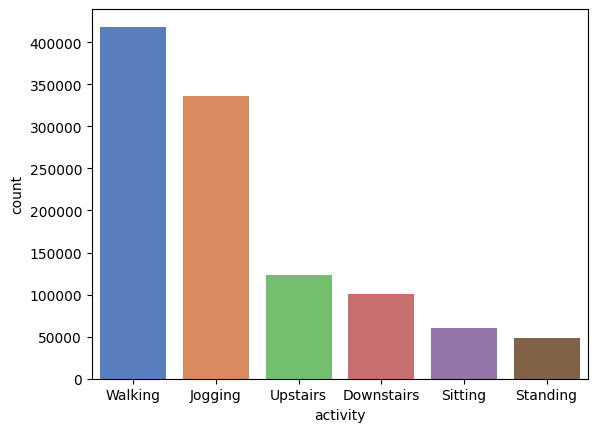

In [4]:
sns.countplot(x='activity', data=df, order = df['activity'].value_counts().index, palette="muted")
plt.show()

## Data Split

In [5]:
df_train = df[df['user_id'] <= 27].copy()
df_test = df[df['user_id'] > 27].copy()

In [6]:
print(df.shape)
print(df_train.shape)
print(df_test.shape)

(1086465, 6)
(801685, 6)
(284780, 6)


## Encoding & Normalization

In [7]:
# Label Encoding
num_cols = ["x", "y", "z"]

le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["activity"])
df_test["label"]  = le.transform(df_test["activity"])

# RobustScaler
scaler = RobustScaler()
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
df_test[num_cols]  = scaler.transform(df_test[num_cols])

## Sliding Windows

In [8]:
def create_sliding_windows_with_group(df, window_size=80, step_size=40):
    data, labels, groups = [], [], []
    values = df[["x", "y", "z"]].values
    acts   = df["label"].values
    users  = df["user_id"].values

    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = values[start:end]
        label  = np.argmax(np.bincount(acts[start:end]))
        user   = users[start]

        data.append(window)
        labels.append(label)
        groups.append(user)

    return np.array(data), np.array(labels), np.array(groups)

X, y, groups = create_sliding_windows_with_group(df_train)
X_test, y_test, groups_test = create_sliding_windows_with_group(df_test)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)
test_ds  = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print("전체:", X.shape, y.shape, groups.shape)

전체: (20041, 80, 3) (20041,) (20041,)


## GroupKFold

In [9]:
gkf = GroupKFold(n_splits=5)

def get_fold_loaders(fold, batch_size=64):
    train_idx, val_idx = list(gkf.split(X, y, groups))[fold]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val     = X[val_idx], y[val_idx]

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    val_ds   = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                             torch.tensor(y_val, dtype=torch.long))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

## Model Creation

In [10]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes=6):
        super(CNN_LSTM, self).__init__()
        
        # --- CNN feature extractor ---
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(64)
        
        # --- LSTM ---
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=1,
                            batch_first=True, bidirectional=False)
        
        # --- FC classifier ---
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, channels) → permute for Conv1d
        x = x.permute(0, 2, 1)               # (batch, channels=3, seq_len=80)

        # CNN feature extractor
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))  # (batch, 64, seq_len)

        # LSTM input은 (batch, seq_len, feature_dim) 형식
        x = x.permute(0, 2, 1)               # (batch, seq_len, feature_dim=64)

        # LSTM
        out, _ = self.lstm(x)                # (batch, seq_len, hidden_dim=128)
        out = out[:, -1, :]                  # 마지막 타임스텝

        # Classifier
        out = self.fc(out)
        return F.log_softmax(out, dim=1)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM(num_classes=6).to(device)
print(device)
print(model)

cuda
CNN_LSTM(
  (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


## Model Training

In [12]:
def train_model(model, train_loader, val_loader, epochs=10):

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(1, epochs+1):
        # --- Training ---
        model.train()
        train_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * xb.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(yb).sum().item()
            total += yb.size(0)
        
        train_acc = correct / total
        train_loss /= total

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item() * xb.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(yb).sum().item()
                val_total += yb.size(0)
        
        val_acc = val_correct / val_total
        val_loss /= val_total

        # --- 로그 저장 ---
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)   
        
        print(f"Epoch {epoch:02d} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")   

    return history


===== Fold 1 =====
Epoch 01 | Train Loss: 0.8267, Acc: 0.6876 | Val Loss: 0.7412, Acc: 0.7132
Epoch 02 | Train Loss: 0.5484, Acc: 0.8146 | Val Loss: 0.6829, Acc: 0.7544
Epoch 03 | Train Loss: 0.4292, Acc: 0.8710 | Val Loss: 0.9245, Acc: 0.7293
Epoch 04 | Train Loss: 0.2770, Acc: 0.9144 | Val Loss: 0.7709, Acc: 0.7985
Epoch 05 | Train Loss: 0.2035, Acc: 0.9392 | Val Loss: 0.8029, Acc: 0.7918
Epoch 06 | Train Loss: 0.1696, Acc: 0.9465 | Val Loss: 0.7616, Acc: 0.8136
Epoch 07 | Train Loss: 0.1544, Acc: 0.9522 | Val Loss: 0.6904, Acc: 0.8169
Epoch 08 | Train Loss: 0.1373, Acc: 0.9585 | Val Loss: 0.8505, Acc: 0.7872
Epoch 09 | Train Loss: 0.1406, Acc: 0.9608 | Val Loss: 0.7510, Acc: 0.7980
Epoch 10 | Train Loss: 0.1242, Acc: 0.9647 | Val Loss: 0.7049, Acc: 0.8335
Epoch 11 | Train Loss: 0.1064, Acc: 0.9700 | Val Loss: 0.6966, Acc: 0.8387
Epoch 12 | Train Loss: 0.0854, Acc: 0.9739 | Val Loss: 0.8133, Acc: 0.7990
Epoch 13 | Train Loss: 0.0925, Acc: 0.9734 | Val Loss: 0.8182, Acc: 0.8020
Epoch

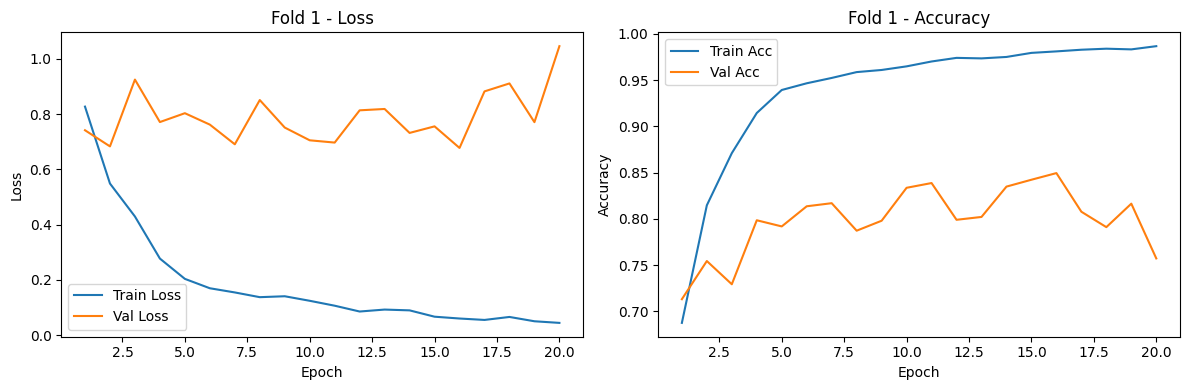

Fold 1 Accuracy: 0.7572

===== Fold 2 =====
Epoch 01 | Train Loss: 0.8938, Acc: 0.6901 | Val Loss: 0.6272, Acc: 0.7971
Epoch 02 | Train Loss: 0.6533, Acc: 0.7553 | Val Loss: 0.5915, Acc: 0.7909
Epoch 03 | Train Loss: 0.4668, Acc: 0.8368 | Val Loss: 0.5370, Acc: 0.7923
Epoch 04 | Train Loss: 0.3536, Acc: 0.8837 | Val Loss: 0.5625, Acc: 0.8057
Epoch 05 | Train Loss: 0.2794, Acc: 0.9195 | Val Loss: 0.6598, Acc: 0.7779
Epoch 06 | Train Loss: 0.2326, Acc: 0.9392 | Val Loss: 0.5897, Acc: 0.8294
Epoch 07 | Train Loss: 0.1783, Acc: 0.9503 | Val Loss: 0.5590, Acc: 0.8459
Epoch 08 | Train Loss: 0.1481, Acc: 0.9576 | Val Loss: 0.4887, Acc: 0.8538
Epoch 09 | Train Loss: 0.1406, Acc: 0.9630 | Val Loss: 0.5355, Acc: 0.8497
Epoch 10 | Train Loss: 0.1328, Acc: 0.9651 | Val Loss: 0.7726, Acc: 0.8057
Epoch 11 | Train Loss: 0.1090, Acc: 0.9709 | Val Loss: 0.6216, Acc: 0.8507
Epoch 12 | Train Loss: 0.0947, Acc: 0.9741 | Val Loss: 0.6713, Acc: 0.8201
Epoch 13 | Train Loss: 0.0901, Acc: 0.9750 | Val Loss: 0

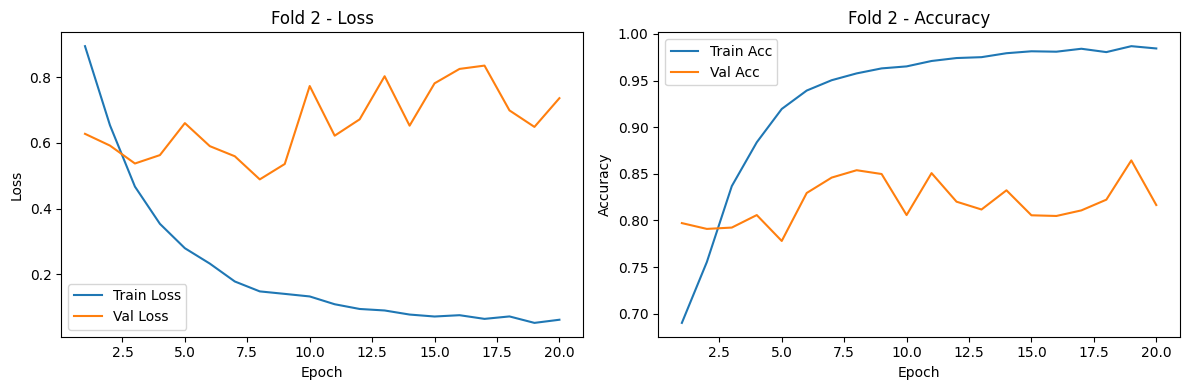

Fold 2 Accuracy: 0.8165

===== Fold 3 =====
Epoch 01 | Train Loss: 0.8236, Acc: 0.7026 | Val Loss: 0.6903, Acc: 0.7401
Epoch 02 | Train Loss: 0.5656, Acc: 0.7825 | Val Loss: 0.7584, Acc: 0.6966
Epoch 03 | Train Loss: 0.3810, Acc: 0.8690 | Val Loss: 0.5603, Acc: 0.7803
Epoch 04 | Train Loss: 0.3097, Acc: 0.8980 | Val Loss: 0.5563, Acc: 0.7949
Epoch 05 | Train Loss: 0.2301, Acc: 0.9254 | Val Loss: 0.7360, Acc: 0.7742
Epoch 06 | Train Loss: 0.1917, Acc: 0.9396 | Val Loss: 0.6997, Acc: 0.7926
Epoch 07 | Train Loss: 0.1579, Acc: 0.9564 | Val Loss: 0.5925, Acc: 0.8277
Epoch 08 | Train Loss: 0.1613, Acc: 0.9584 | Val Loss: 0.5220, Acc: 0.8382
Epoch 09 | Train Loss: 0.1277, Acc: 0.9662 | Val Loss: 0.4838, Acc: 0.8443
Epoch 10 | Train Loss: 0.1145, Acc: 0.9707 | Val Loss: 0.4877, Acc: 0.8638
Epoch 11 | Train Loss: 0.0997, Acc: 0.9750 | Val Loss: 0.5452, Acc: 0.8510
Epoch 12 | Train Loss: 0.0947, Acc: 0.9756 | Val Loss: 0.6474, Acc: 0.8356
Epoch 13 | Train Loss: 0.0789, Acc: 0.9795 | Val Loss: 0

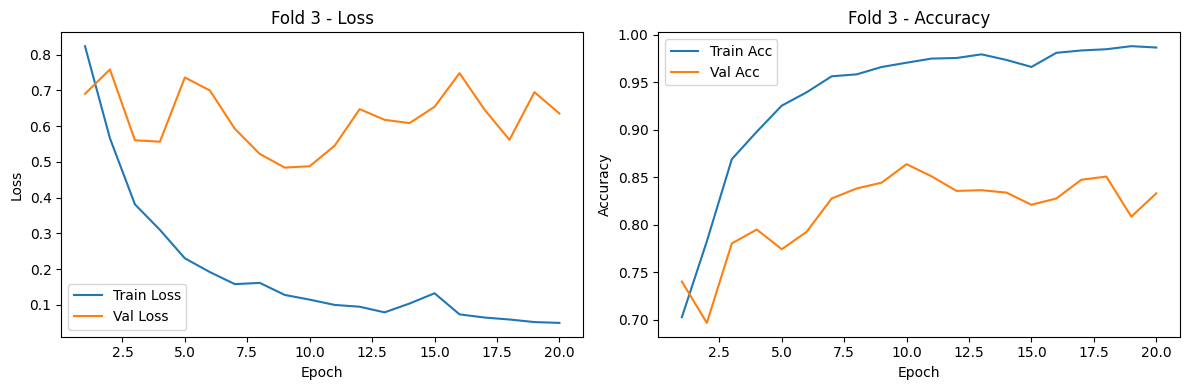

Fold 3 Accuracy: 0.8331

===== Fold 4 =====
Epoch 01 | Train Loss: 0.7727, Acc: 0.7088 | Val Loss: 1.1045, Acc: 0.5650
Epoch 02 | Train Loss: 0.5296, Acc: 0.8107 | Val Loss: 0.9671, Acc: 0.6660
Epoch 03 | Train Loss: 0.3925, Acc: 0.8690 | Val Loss: 0.8332, Acc: 0.7243
Epoch 04 | Train Loss: 0.3113, Acc: 0.9016 | Val Loss: 0.9417, Acc: 0.6895
Epoch 05 | Train Loss: 0.2609, Acc: 0.9232 | Val Loss: 0.8924, Acc: 0.7157
Epoch 06 | Train Loss: 0.1894, Acc: 0.9463 | Val Loss: 0.9068, Acc: 0.7260
Epoch 07 | Train Loss: 0.1859, Acc: 0.9459 | Val Loss: 0.9448, Acc: 0.7414
Epoch 08 | Train Loss: 0.2175, Acc: 0.9321 | Val Loss: 0.9865, Acc: 0.7147
Epoch 09 | Train Loss: 0.1528, Acc: 0.9524 | Val Loss: 1.0115, Acc: 0.7121
Epoch 10 | Train Loss: 0.1045, Acc: 0.9701 | Val Loss: 1.1116, Acc: 0.7102
Epoch 11 | Train Loss: 0.1385, Acc: 0.9611 | Val Loss: 1.1508, Acc: 0.7145
Epoch 12 | Train Loss: 0.1034, Acc: 0.9696 | Val Loss: 1.0643, Acc: 0.7080
Epoch 13 | Train Loss: 0.0953, Acc: 0.9723 | Val Loss: 1

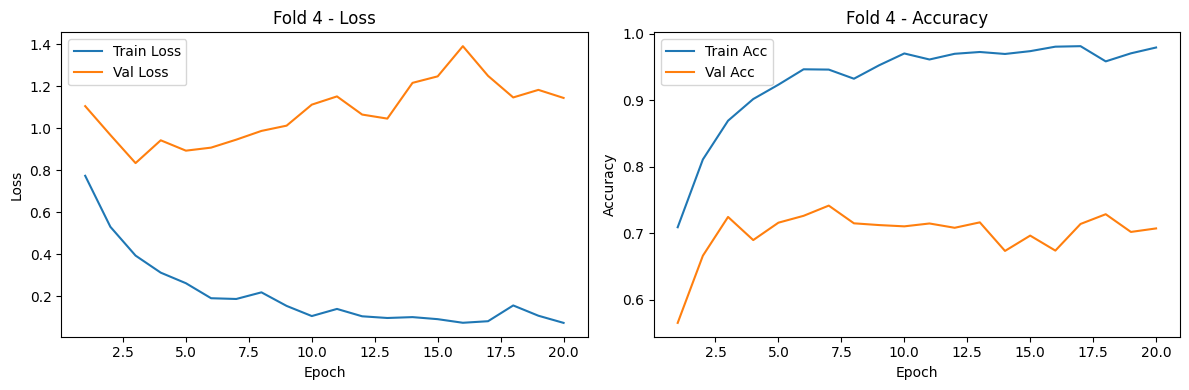

Fold 4 Accuracy: 0.7071

===== Fold 5 =====
Epoch 01 | Train Loss: 0.8327, Acc: 0.6834 | Val Loss: 0.9610, Acc: 0.6096
Epoch 02 | Train Loss: 0.5921, Acc: 0.7622 | Val Loss: 0.5730, Acc: 0.7383
Epoch 03 | Train Loss: 0.4897, Acc: 0.8176 | Val Loss: 0.3465, Acc: 0.8633
Epoch 04 | Train Loss: 0.3622, Acc: 0.8809 | Val Loss: 0.3094, Acc: 0.8743
Epoch 05 | Train Loss: 0.2696, Acc: 0.9171 | Val Loss: 0.2743, Acc: 0.9037
Epoch 06 | Train Loss: 0.2208, Acc: 0.9331 | Val Loss: 0.2877, Acc: 0.8905
Epoch 07 | Train Loss: 0.1747, Acc: 0.9491 | Val Loss: 0.2087, Acc: 0.9292
Epoch 08 | Train Loss: 0.1559, Acc: 0.9562 | Val Loss: 0.1836, Acc: 0.9338
Epoch 09 | Train Loss: 0.1455, Acc: 0.9587 | Val Loss: 0.2007, Acc: 0.9294
Epoch 10 | Train Loss: 0.1231, Acc: 0.9658 | Val Loss: 0.1988, Acc: 0.9158
Epoch 11 | Train Loss: 0.1089, Acc: 0.9692 | Val Loss: 0.2073, Acc: 0.9312
Epoch 12 | Train Loss: 0.1044, Acc: 0.9725 | Val Loss: 0.2252, Acc: 0.9312
Epoch 13 | Train Loss: 0.1091, Acc: 0.9700 | Val Loss: 0

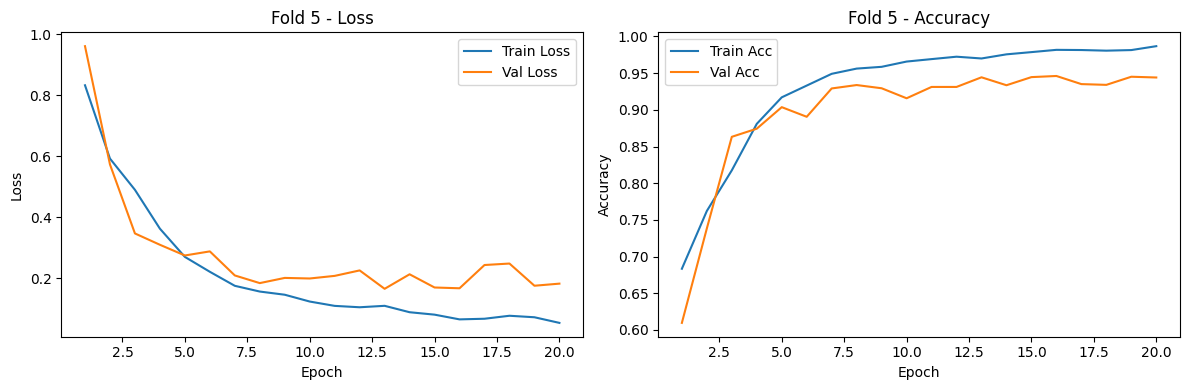

Fold 5 Accuracy: 0.9441

=== K-Fold 평균 정확도 ===
Mean Acc: 0.8116, Std: 0.0799


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_val_acc = 0.0
best_model_state = None
best_class_weights = None


fold_accs = []
for fold in range(5):
    print(f"\n===== Fold {fold+1} =====")
    train_loader, val_loader = get_fold_loaders(fold, batch_size=64)
    
    model = CNN_LSTM(num_classes=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 클래스 가중치 (train fold 기준)
    y_train_fold = np.array([y for _, y in train_loader.dataset])
    classes, counts = np.unique(y_train_fold, return_counts=True)
    weights = (counts.sum() / (len(classes) * counts)).astype(np.float32)
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # 학습 (히스토리 저장)
    history = train_model(model, train_loader, val_loader, epochs=20)

    # fold 최고 성능 기록
    val_acc = max(history["val_acc"])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        best_class_weights = class_weights

    # 시각화
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(12,4))

    # Loss 곡선
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"Fold {fold+1} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(False)

    # Accuracy 곡선
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(f"Fold {fold+1} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(False)

    plt.tight_layout()
    plt.show()
    
    # fold 성능 저장
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(yb).sum().item()
            val_total += yb.size(0)
    acc = val_correct / val_total
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")
    fold_accs.append(acc)

print("\n=== K-Fold 평균 정확도 ===")
print(f"Mean Acc: {np.mean(fold_accs):.4f}, Std: {np.std(fold_accs):.4f}")

## Check class distribution by Fold

In [14]:
# Fold별 class 분포 확인
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    y_val = y[val_idx]
    counts = pd.Series(y_val).value_counts(normalize=True).sort_index()
    print(f"\nFold {fold+1} Validation Set Class Distribution:")
    for cls_idx, ratio in counts.items():
        print(f"  Class {cls_idx}: {ratio:.2%}")


Fold 1 Validation Set Class Distribution:
  Class 0: 8.32%
  Class 1: 30.35%
  Class 2: 13.55%
  Class 3: 6.84%
  Class 4: 8.94%
  Class 5: 32.01%

Fold 2 Validation Set Class Distribution:
  Class 0: 6.96%
  Class 1: 30.82%
  Class 2: 4.19%
  Class 3: 3.59%
  Class 4: 9.52%
  Class 5: 44.92%

Fold 3 Validation Set Class Distribution:
  Class 0: 7.94%
  Class 1: 35.69%
  Class 2: 3.81%
  Class 3: 4.97%
  Class 4: 9.83%
  Class 5: 37.76%

Fold 4 Validation Set Class Distribution:
  Class 0: 10.68%
  Class 1: 28.77%
  Class 2: 3.02%
  Class 3: 1.92%
  Class 4: 15.76%
  Class 5: 39.85%

Fold 5 Validation Set Class Distribution:
  Class 0: 10.76%
  Class 1: 35.05%
  Class 2: 1.80%
  Class 3: 2.86%
  Class 4: 12.41%
  Class 5: 37.11%


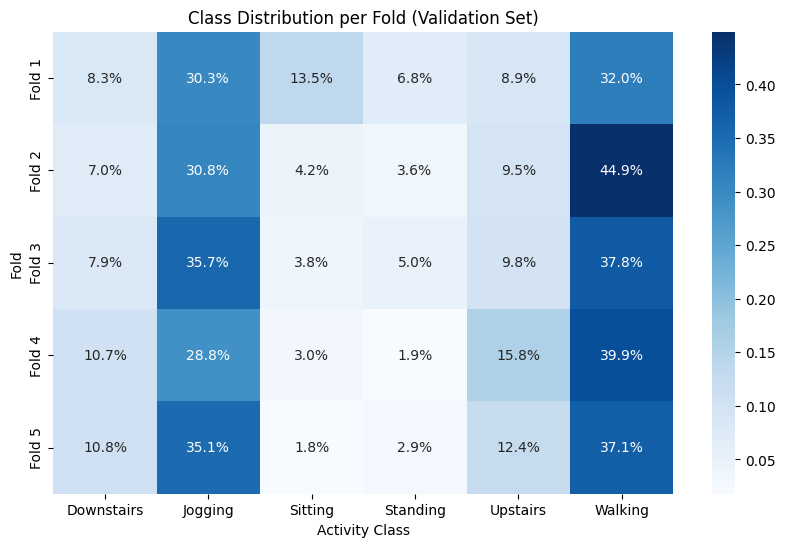

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

dist_per_fold = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    y_val = y[val_idx]
    counts = pd.Series(y_val).value_counts(normalize=True).sort_index()
    dist_per_fold.append(counts)

dist_df = pd.DataFrame(dist_per_fold).fillna(0)
dist_df.index = [f"Fold {i+1}" for i in range(len(dist_df))]
dist_df.columns = le.classes_  # activity 이름으로 열 바꾸기

plt.figure(figsize=(10,6))
sns.heatmap(dist_df, annot=True, fmt=".1%", cmap="Blues")
plt.title("Class Distribution per Fold (Validation Set)")
plt.ylabel("Fold")
plt.xlabel("Activity Class")
plt.show()

## Model Evaluation

In [16]:
# test
def test_loop(model, test_loader, criterion, device="cpu"):
    model.eval()  # 평가 모드 (Dropout/BatchNorm 비활성화)
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():  # 테스트 시에는 gradient 계산 끔
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)

            # forward
            outputs = model(xb)
            loss = criterion(outputs, yb)

            # 손실 누적 (평균 내기 위해 샘플 수 곱해줌)
            test_loss += loss.item() * xb.size(0)

            # 예측값
            _, predicted = outputs.max(1)
            correct += predicted.eq(yb).sum().item()
            total += yb.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    
    avg_loss = test_loss / total
    acc = correct / total
    return avg_loss, acc, np.array(all_preds), np.array(all_labels)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNN_LSTM(num_classes=6).to(device)
model.load_state_dict(best_model_state)

criterion = nn.CrossEntropyLoss(weight=best_class_weights)

test_loss, test_acc, all_preds, all_labels = test_loop(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.6992, Test Accuracy: 0.8540


In [18]:
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

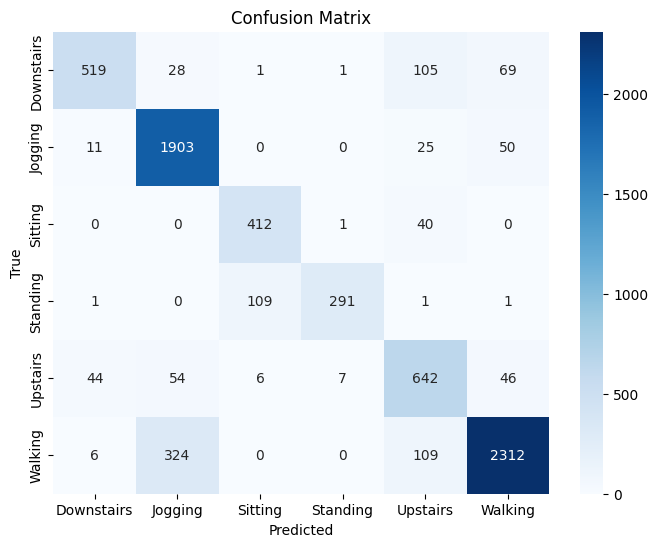

In [19]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [20]:
print(classification_report(all_labels, all_preds, target_names=le.classes_))

              precision    recall  f1-score   support

  Downstairs       0.89      0.72      0.80       723
     Jogging       0.82      0.96      0.89      1989
     Sitting       0.78      0.91      0.84       453
    Standing       0.97      0.72      0.83       403
    Upstairs       0.70      0.80      0.75       799
     Walking       0.93      0.84      0.88      2751

    accuracy                           0.85      7118
   macro avg       0.85      0.83      0.83      7118
weighted avg       0.86      0.85      0.85      7118

